<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-summary" data-toc-modified-id="Data-summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data summary</a></span></li><li><span><a href="#Quality-Control" data-toc-modified-id="Quality-Control-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Quality Control</a></span><ul class="toc-item"><li><span><a href="#Population-Distributions" data-toc-modified-id="Population-Distributions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Population Distributions</a></span></li><li><span><a href="#Control-Distributions" data-toc-modified-id="Control-Distributions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Control Distributions</a></span></li><li><span><a href="#ROC-AUC" data-toc-modified-id="ROC-AUC-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>ROC-AUC</a></span></li></ul></li><li><span><a href="#Gene-level-analysis" data-toc-modified-id="Gene-level-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gene level analysis</a></span><ul class="toc-item"><li><span><a href="#Residual-z-scores" data-toc-modified-id="Residual-z-scores-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Residual z-scores</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp

from poola import core as pool

import core_functions as fns

gpp.set_aesthetics(palette='Set2')



In [2]:
import anchors
import statsmodels
from scipy import stats

def group_cols(df, initial_id = 'ini', res_id = 'res', col_type = 'LFC'): #if more than one set of initial/resistant pop pairs, sharex = True, store pairs in list
    '''
    Inputs: 
    1. df: Dataframe containing log-fold change values and gene symbols 
    2. initial_id: string identifying initial column names (default: 'control'), only used if multiple subplots
    3. res_id: string identifying resistant column names (default: 'MOI'), only used if multiple subplots
    4. col_type: string in names of columns containing data to be plotted (default: 'lfc')
    Outputs: 
    1. sharex: if number of pairs greater than 1 indicating multiple subplots
    2. pairs: pairs of initial and resistant populations as list of lists     
    '''
    cols = [col for col in df.columns if col_type in col]
    pairs = [] #list of lists: ini/res pop pairs
    if len(cols) > 2: #if more than one set of initial/resistant pop pairs 
        sharex = True # set sharex parameter for subplot 
        for index, col in enumerate(cols):
            pair = []
            if initial_id in col: #find corresponding resistant pop
                pair.append(col)
                split_col = col.split('_')
                ini_index = split_col.index(initial_id)
                res_col_string = '_'.join(split_col[:ini_index])
                print(res_col_string)
                if 'screen' in col: 
                    screen_index = split_col.index('screen')
                    screen = split_col[screen_index]
                    number = split_col[screen_index+1]
                    screen_str = screen + ' ' + number 
                    #res_col_string = res_col_string + ' ' + screen_str
                    print(res_col_string)
                    res_pop = [col for col in cols if (res_col_string in col) and (res_id in col)]# and (screen_str in col)]
                else:
                    res_pop = [col for col in cols if (res_col_string in col) and (res_id in col) and ('screen' not in col)]

                print(res_pop)
                for col in res_pop:
                    pair.append(col)
                    
                pairs.append(pair) #add to list of pairs (list of lists)
        return sharex, pairs
    else: #if only one pair of initial/resistant pops
        sharex = False
        pairs.append(cols)
        return sharex, pairs
    
def run_guide_residuals(lfc_df):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Input:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    '''
    paired_lfc_cols = group_cols(lfc_df)[1] #get lfc pairs

    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots



## Data summary

* Cell line: Caco-2
* Library: Brunello

In [3]:
reads_plate1 = pd.read_csv('../../Data/Reads/Goujon/Caco2/counts-JD_GPP1887_Goujon_Plate1.txt', sep ='\t')


In [4]:
bru_goujon_lfc = pd.read_csv('../../Data/Interim/Goujon/Caco2/Brunello_pDNA_LFC_ann.txt', sep='\t')
Huh_cols = [col for col in bru_goujon_lfc.columns if 'Huh' in col]
Caco_lfc = bru_goujon_lfc.copy().drop(Huh_cols, axis =1)
Caco_lfc

,sgRNA Sequence,Caco2_1_ini_pop_LFC,Caco2_1_res_pop_LFC,Caco2_2.1_ini_pop_LFC,Caco2_2.1_res_pop_LFC,Barcode Sequence,Gene Symbol,Gene ID
0,AAAAAAAATCCGGACAATGG,-0.627596,-4.192756,-0.116111,-4.192756,AAAAAAAATCCGGACAATGG,SLC25A24,29957
1,AAAAAAAGGATGGTGATCAA,0.329512,-2.425958,-0.336067,-4.127852,AAAAAAAGGATGGTGATCAA,FASTKD3,79072
2,AAAAAAATGACATTACTGCA,-0.809971,-4.041390,0.005114,-4.041390,AAAAAAATGACATTACTGCA,BCAS2,10286
3,AAAAAAATGTCAGTCGAGTG,0.188302,-2.930437,-0.026835,-2.930437,AAAAAAATGTCAGTCGAGTG,GPR18,2841
4,AAAAAACACAAGCAAGACCG,-0.734830,-3.388394,-0.177961,-3.388394,AAAAAACACAAGCAAGACCG,ZNF470,388566
...,...,...,...,...,...,...,...,...
87443,TTTTGACTCTAATCACCGGT,0.615543,-3.948733,0.014619,-4.319765,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54,INACTIVE_4T_54
87444,TTTTTAATACAAGGTAATCT,0.311723,-3.304341,-0.038510,-4.142241,TTTTTAATACAAGGTAATCT,NO_SITE_940,NO_SITE_940
87445,TTTTTAATACAAGGTAATCT,0.311723,-3.304341,-0.038510,-4.142241,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,INACTIVE_5T_55
87446,TTTTTCTCACCCGATGAATC,-0.181965,-4.516670,0.126258,-4.516670,TTTTTCTCACCCGATGAATC,NO_SITE_941,NO_SITE_941


In [5]:
controls_dict = fns.get_controls(Caco_lfc, control_name=['NO_SITE', 'ONE_INTERGENIC'], separate=True)

## Quality Control
### Population Distributions

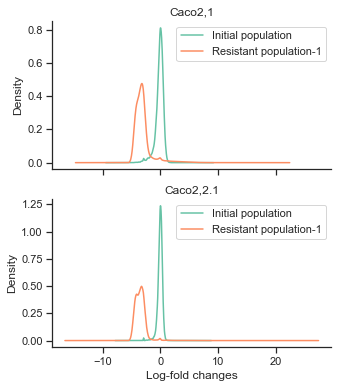

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5,6))
i,j = 0,0
cols = [['Caco2_1_ini_pop_LFC','Caco2_1_res_pop_LFC'],['Caco2_2.1_ini_pop_LFC','Caco2_2.1_res_pop_LFC']]
for k,c in enumerate(cols):
    for l, c1 in enumerate(c):
        if l==0:
            label1 = 'Initial population'
        else:
            label1 = 'Resistant population-'+str(l)
        Caco_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax[i], legend=True)
        sns.despine()
        t = ax[i].set_xlabel('Log-fold changes')
        title = ','.join(c1.split('_')[:2])
        t = ax[i].set_title(title)
    i+=1
    
fig.savefig('../../Figures/Caco2_distributions.png', bbox_inches="tight")

### Control Distributions 

0 ['Caco2_1_ini_pop_LFC', 'Caco2_1_res_pop_LFC']
1 ['Caco2_2.1_ini_pop_LFC', 'Caco2_2.1_res_pop_LFC']


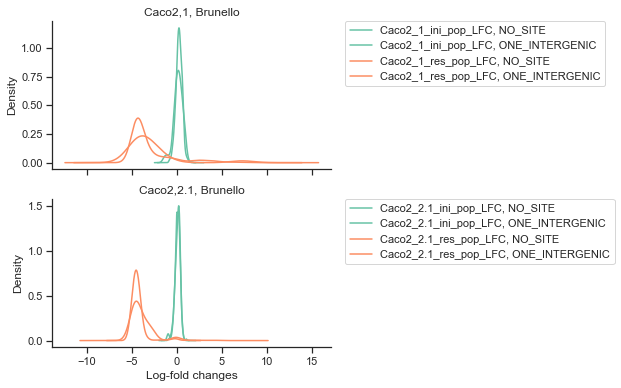

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5,6))
i,j = 0,0
cols = [['Caco2_1_ini_pop_LFC','Caco2_1_res_pop_LFC'],['Caco2_2.1_ini_pop_LFC','Caco2_2.1_res_pop_LFC']]


for k,c in enumerate(cols):
    print(k, c)
    for l, c1 in enumerate(c): 
        for key, controls in controls_dict.items():
            controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label= c1+', '+ key, ax=ax[i], legend=True)

    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    t = ax[i].set_xlabel('Log-fold changes')
    title = ','.join(c[0].split('_')[:2])+', Brunello'
    t = ax[i].set_title(title)
    i+=1

fig.savefig('../../Figures/Caco2_control_distributions.png', bbox_inches="tight")

### ROC-AUC

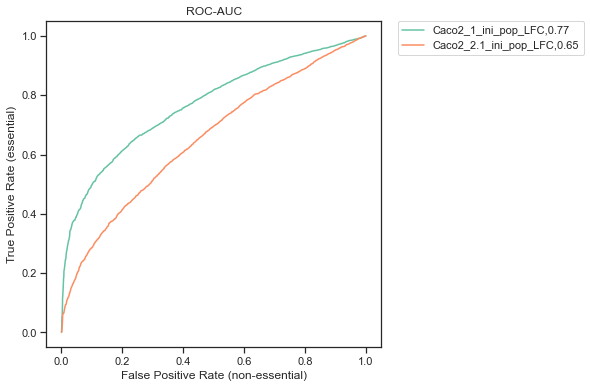

In [8]:
ess_genes, non_ess_genes = fns.get_gene_sets()

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_cols = [col for col in Caco_lfc.columns if 'ini' in col]
initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(Caco_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')

fig.savefig('../../Figures/Caco2ROCAUC.png', bbox_inches = 'tight')

## Gene level analysis

### Residual z-scores

In [9]:
Caco_lfc = Caco_lfc.drop(['Barcode Sequence', 'Gene Symbol', 'Gene ID'], axis=1).drop_duplicates() 
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(Caco_lfc)

Caco2_1
['Caco2_1_res_pop_LFC']
Caco2_2.1
['Caco2_2.1_res_pop_LFC']
                modified            unperturbed
0    Caco2_1_res_pop_LFC    Caco2_1_ini_pop_LFC
1  Caco2_2.1_res_pop_LFC  Caco2_2.1_ini_pop_LFC


In [10]:
Brunello_chip = pd.read_csv('../../Data/Interim/Goujon/Caco2/CP0041_GRCh38_NCBI_strict_gene_20200612.chip', '\t')
Brunello_chip =  Brunello_chip.drop('Gene ID', axis = 1)
Brunello_chip = Brunello_chip.rename(columns = {'Barcode Sequence':'sgRNA Sequence'})
guide_mapping = pool.group_pseudogenes(Brunello_chip, pseudogene_size=4, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC', 'NO_SITE'])

In [11]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Caco2_1_res_pop_LFC,A1BG,4,-2.373616,-0.066135,1.012171,0.311456,0.999924
1,Caco2_1_res_pop_LFC,A1CF,4,-3.496826,0.292378,-0.676727,0.498579,0.999924
2,Caco2_1_res_pop_LFC,A2M,4,-1.758410,0.119551,1.734995,0.082742,0.993746
3,Caco2_1_res_pop_LFC,A2ML1,4,-3.641734,-0.054713,-0.754240,0.450705,0.999924
4,Caco2_1_res_pop_LFC,A3GALT2,4,-2.965426,0.002172,0.161350,0.871818,0.999924
...,...,...,...,...,...,...,...,...
42295,Caco2_2.1_res_pop_LFC,ZYG11A,4,-2.567325,-0.033578,2.044485,0.040906,0.548608
42296,Caco2_2.1_res_pop_LFC,ZYG11B,4,-3.540109,0.047652,-0.194975,0.845413,0.966856
42297,Caco2_2.1_res_pop_LFC,ZYX,4,-3.616438,0.109451,-0.301356,0.763143,0.945411
42298,Caco2_2.1_res_pop_LFC,ZZEF1,4,-4.171081,-0.221864,-1.252995,0.210208,0.805076


In [12]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 3, guide_max = 5)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'sgRNA Sequence', how = 'inner')

['Caco2_2.1_res_pop_LFC', 'Caco2_1_res_pop_LFC']
Caco2_2.1_res_pop_LFC
Caco2_1_res_pop_LFC


In [13]:
with pd.ExcelWriter('../../Data/Processed/GEO_submission_v2/Caco2_Brunello_Goujon_v2.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Caco2_Brunello_avg_zscore', index =False)
    reads_plate1.to_excel(writer, sheet_name='Caco2_Brunello_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Caco2_Brunello_guide_mapping', index =False)

In [14]:
with pd.ExcelWriter('../../Data/Processed/Individual_screens_v2/Caco2_Brunello_Goujon_v3.xlsx') as writer:   
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)